<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/KMG/GraphCodeBERT_dacon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import random
from itertools import combinations, product
import re
import sklearn
from sklearn.model_selection import train_test_split
import torch
torch.set_float32_matmul_precision('high')
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Seed 고정 함수
def seed_everything(seed: int = 42, contain_cuda: bool = False):
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  print(f"Seed set as {seed}")

seed = 42
seed_everything(seed)

Seed set as 42


In [3]:
# CUDA 사용 가능 여부 확인 및 GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
def preprocess_and_remove_extras(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()

    content = re.sub(re.compile("/\*.*?\*/", re.DOTALL), "", content) # 멀티 라인 주석 제거
    content = re.sub(re.compile("//.*?\n"), "", content) # 싱글 라인 주석 제거
    content = re.sub(re.compile("#include <.*?>\n"), "", content) # angle brackets를 사용하는 include 제거
    content = re.sub(re.compile("#include \".*?\"\n"), "", content) # double quotes를 사용하는 include 제거
    content = re.sub(re.compile("#define .*?\n"), "", content) # 매크로 정의 제거
    content = re.sub(re.compile("[\t ]+"), " ", content) # 공백 및 탭 정리
    content = re.sub(re.compile("\n\s*\n"), "\n", content)# 여러 줄바꿈을 하나로

    # 공백이 아닌 줄만 선택하여 리스트로 만든 후, 문자열로 결합
    processed_script = '\n'.join([line.strip() for line in content.splitlines() if line.strip()])

    return processed_script

In [12]:
#  전처리 적용
#  이미 create_train_data 만들 때 적용했지만, test.csv와, sample_train.csv에도 같은 전처리를 하기 위해 다시 정의
def remove_extras(code):
    code = re.sub(re.compile("/\*.*?\*/", re.DOTALL), "", code) # 멀티 라인 주석 제거
    code = re.sub(re.compile("//.*?\n"), "", code) # 싱글 라인 주석 제거
    code = re.sub(re.compile("#include <.*?>\n"), "", code)  # angle brackets를 사용하는 include 제거
    code = re.sub(re.compile("#include \".*?\"\n"), "", code)  # double quotes를 사용하는 include 제거
    code = re.sub(re.compile("#define .*?\n"), "", code)  # 매크로 정의 제거
    code = re.sub(re.compile("[\t ]+"), " ", code)  # 탭과 여러 공백을 하나의 공백으로
    code = re.sub(re.compile("\n\s*\n"), "\n", code)  # 여러 줄바꿈을 하나로

    return code.strip()

In [14]:
class CodeDataset(Dataset):
    def __init__(self, tokenizer, data, max_length=512, include_labels=True):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        code = remove_extras(self.data.iloc[idx]['code'])  # 특정 인덱스의 코드를 가져와 추가 요소를 제거합니다.

        inputs = self.tokenizer(
            code,
            padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        inputs = {key: val.squeeze() for key, val in inputs.items()}

        label = torch.tensor(self.data.iloc[idx]['labels'], dtype=torch.long)  # 해당 코드의 정답 라벨을 가져옵니다.
        inputs['labels'] = label

        return inputs

In [15]:
filepath_train = '/content/drive/MyDrive/Dataset/final/final_train5.csv'
filepath_val = '/content/drive/MyDrive/Dataset/final/final_val2.csv'
train_df = pd.read_csv(filepath_train)
val_df = pd.read_csv(filepath_val)

In [16]:
train_df = train_df.drop(columns=['Unnamed: 0'])
val_df = val_df.drop(columns=['Unnamed: 0'])
train_df = train_df.drop(columns=['vul'])
val_df = val_df.drop(columns=['vul'])

In [17]:
# GraphCodeBERT 모델 및 토크나이저 로드
model_name = "microsoft/graphcodebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.truncation_side = "left"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=11).to(device)

# 훈련 세트와 검증 세트에 대한 데이터셋 생성
train_dataset = CodeDataset(tokenizer, train_df, max_length=512)
val_dataset = CodeDataset(tokenizer, val_df, max_length=512, include_labels=True)

# 데이터 로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 파인 튜닝을 위한 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 360/360 [01:09<00:00,  5.19it/s]


Epoch 1, Training Loss: 0.7554465476978521, Train F1 Score: 0.738260029118475, Validation Loss: 0.5436906821792945, Validation F1 Score: 0.7888712261134518
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.38      0.97      0.55       676
           2       0.82      0.23      0.36       590
           3       1.00      1.00      1.00       523
           4       1.00      0.97      0.98       512
           5       0.97      0.99      0.98       504
           6       0.99      0.93      0.96       484
           7       0.83      0.35      0.49       432
           8       0.95      0.84      0.89       419
           9       0.87      0.50      0.64       365
          10       0.93      0.59      0.72       344

    accuracy                           0.79      5749
   macro avg       0.89      0.76      0.78      5749
weighted avg       0.88      0.79      0.79      5749



100%|██████████| 360/360 [01:09<00:00,  5.17it/s]


Epoch 2, Training Loss: 0.3302877381170908, Train F1 Score: 0.8902586696881591, Validation Loss: 0.3038710295303544, Validation F1 Score: 0.903065915335675
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.91      0.72      0.80       676
           2       0.75      0.74      0.75       590
           3       1.00      1.00      1.00       523
           4       0.98      1.00      0.99       512
           5       1.00      0.98      0.99       504
           6       1.00      0.94      0.96       484
           7       0.66      0.89      0.76       432
           8       0.94      0.93      0.94       419
           9       0.73      0.91      0.81       365
          10       0.95      0.78      0.86       344

    accuracy                           0.90      5749
   macro avg       0.90      0.90      0.90      5749
weighted avg       0.91      0.90      0.90      5749



100%|██████████| 360/360 [01:09<00:00,  5.18it/s]


Epoch 3, Training Loss: 0.15207077685690287, Train F1 Score: 0.9521636394339082, Validation Loss: 0.22622414780214764, Validation F1 Score: 0.9303977734632467
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.92      0.86      0.89       676
           2       0.77      0.80      0.78       590
           3       1.00      1.00      1.00       523
           4       0.98      1.00      0.99       512
           5       1.00      0.98      0.99       504
           6       0.99      0.96      0.97       484
           7       0.83      0.88      0.85       432
           8       0.95      0.94      0.94       419
           9       0.84      0.89      0.87       365
          10       0.92      0.88      0.90       344

    accuracy                           0.93      5749
   macro avg       0.93      0.93      0.93      5749
weighted avg       0.93      0.93      0.93      5749



100%|██████████| 360/360 [01:09<00:00,  5.17it/s]


Epoch 4, Training Loss: 0.07710592059531783, Train F1 Score: 0.9768344947249576, Validation Loss: 0.24558494335586956, Validation F1 Score: 0.9370208483351891
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.90      0.88      0.89       676
           2       0.81      0.80      0.80       590
           3       1.00      1.00      1.00       523
           4       0.98      1.00      0.99       512
           5       1.00      0.98      0.99       504
           6       0.99      0.96      0.98       484
           7       0.87      0.89      0.88       432
           8       0.99      0.92      0.95       419
           9       0.79      0.95      0.86       365
          10       0.95      0.89      0.92       344

    accuracy                           0.94      5749
   macro avg       0.93      0.93      0.93      5749
weighted avg       0.94      0.94      0.94      5749



100%|██████████| 360/360 [01:09<00:00,  5.17it/s]


Epoch 5, Training Loss: 0.06382186356440733, Train F1 Score: 0.9797330803380785, Validation Loss: 0.27329488937854574, Validation F1 Score: 0.9370136424178876
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.91      0.88      0.89       676
           2       0.82      0.80      0.81       590
           3       1.00      1.00      1.00       523
           4       0.98      0.99      0.99       512
           5       0.99      0.99      0.99       504
           6       0.99      0.95      0.97       484
           7       0.77      0.92      0.84       432
           8       0.97      0.95      0.96       419
           9       0.93      0.88      0.91       365
          10       0.93      0.90      0.91       344

    accuracy                           0.94      5749
   macro avg       0.93      0.93      0.93      5749
weighted avg       0.94      0.94      0.94      5749



100%|██████████| 360/360 [01:09<00:00,  5.18it/s]


Epoch 6, Training Loss: 0.046733169716184, Train F1 Score: 0.9850263529210792, Validation Loss: 0.2482052051151792, Validation F1 Score: 0.9412300372890479
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.86      0.93      0.89       676
           2       0.81      0.84      0.82       590
           3       1.00      1.00      1.00       523
           4       0.98      0.99      0.99       512
           5       0.99      0.98      0.99       504
           6       0.98      0.97      0.97       484
           7       0.93      0.84      0.88       432
           8       0.97      0.95      0.96       419
           9       0.93      0.88      0.90       365
          10       0.90      0.92      0.91       344

    accuracy                           0.94      5749
   macro avg       0.94      0.94      0.94      5749
weighted avg       0.94      0.94      0.94      5749



100%|██████████| 360/360 [01:09<00:00,  5.19it/s]


Epoch 7, Training Loss: 0.045737179605339136, Train F1 Score: 0.9849401091822657, Validation Loss: 0.2520915587768387, Validation F1 Score: 0.9428281702461863
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.92      0.87      0.90       676
           2       0.78      0.86      0.82       590
           3       1.00      1.00      1.00       523
           4       0.98      1.00      0.99       512
           5       1.00      0.98      0.99       504
           6       1.00      0.97      0.98       484
           7       0.88      0.89      0.88       432
           8       0.97      0.94      0.95       419
           9       0.95      0.89      0.92       365
          10       0.88      0.94      0.91       344

    accuracy                           0.94      5749
   macro avg       0.94      0.94      0.94      5749
weighted avg       0.94      0.94      0.94      5749



100%|██████████| 360/360 [01:09<00:00,  5.18it/s]


Epoch 8, Training Loss: 0.03869157257822594, Train F1 Score: 0.9873287708033975, Validation Loss: 0.27612900221124115, Validation F1 Score: 0.9404452268590912
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.94      0.83      0.88       676
           2       0.78      0.86      0.82       590
           3       1.00      1.00      1.00       523
           4       0.98      0.99      0.99       512
           5       0.99      0.99      0.99       504
           6       1.00      0.96      0.98       484
           7       0.83      0.91      0.86       432
           8       0.98      0.95      0.96       419
           9       0.90      0.92      0.91       365
          10       0.92      0.92      0.92       344

    accuracy                           0.94      5749
   macro avg       0.94      0.94      0.94      5749
weighted avg       0.94      0.94      0.94      5749

Early

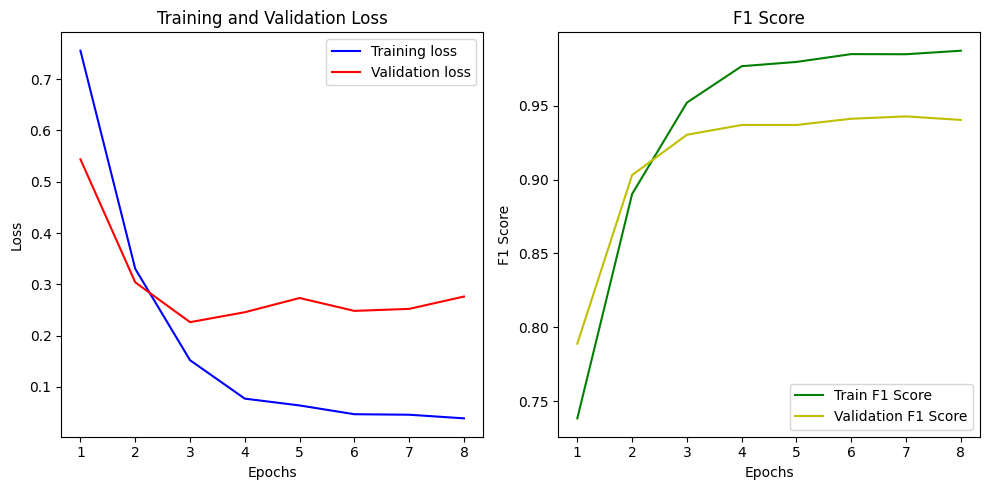

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

model.train()
best_val_loss = float('inf')  # 최고 검증 손실값을 추적하기 위한 변수
patience = 5  # 얼리스탑을 수행할 횟수
early_stopping_counter = 0  # 얼리스탑을 위한 카운터

for epoch in range(600):  # 예시로 3 에폭으로 설정
    total_loss = 0
    all_predictions_train = []
    all_labels_train = []
    model.train()
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        labels = batch["labels"]

        all_predictions_train.extend(predictions.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 에폭당 평균 훈련 손실 계산
    epoch_loss = total_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # train F1-score 계산
    train_f1 = f1_score(all_labels_train, all_predictions_train, average='weighted')
    train_f1_scores.append(train_f1)

    # 검증 세트를 이용한 검증 손실 및 F1 점수 계산
    model.eval()
    total_val_loss = 0
    all_predictions_val = []
    all_labels_val = []
    for batch in tqdm(val_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        total_val_loss += loss.item()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        labels = batch["labels"]

        all_predictions_val.extend(predictions.cpu().numpy())
        all_labels_val.extend(labels.cpu().numpy())

    # 검증 세트에 대한 평균 손실 계산
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # val F1-score 계산
    val_f1 = f1_score(all_labels_val, all_predictions_val, average='weighted')
    val_f1_scores.append(val_f1)

    # 클래스별 F1-score 계산
    class_report = classification_report(all_labels_val, all_predictions_val)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss}, Train F1 Score: {train_f1}, Validation Loss: {avg_val_loss}, Validation F1 Score: {val_f1}")
    print("Classification Report:")
    print(class_report)

    # 검증 손실이 이전 최고값보다 낮으면 모델 저장하고 최고값 업데이트
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        early_stopping_counter = 0  # 검증 손실이 개선되면 카운터 초기화
    else:
        early_stopping_counter += 1  # 검증 손실이 개선되지 않으면 카운터 증가
        if early_stopping_counter >= patience:
            print("Early stopping.")
            break

# 그래프로 나타내기
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1_scores, 'g', label='Train F1 Score')
plt.plot(epochs, val_f1_scores, 'y', label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# 검증 세트를 이용한 모델 평가
model.eval()
total_eval_accuracy = 0
for batch in tqdm(val_loader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    labels = batch["labels"]

    # 정확도 계산
    accuracy = (predictions == labels).cpu().numpy().mean() * 100
    total_eval_accuracy += accuracy

# 에폭당 평균 검증 정확도 계산
avg_val_accuracy = total_eval_accuracy / len(val_loader)
print(f"Validation Accuracy: {avg_val_accuracy:.2f}%")

100%|██████████| 20/20 [00:05<00:00,  3.50it/s]

Validation Accuracy: 100.00%
